En la siguiente notebook se resolvera exclusivamente el ejecicio nro 3 - Data Science, esto lo hice asi para dar mayor prolijidad al codigo y no complicar la lectura.

### Importo las librerias a utilizar|

In [1]:
# Data analysis y wrangling.
import pandas as pd
import numpy as np

# Librerias graficas.
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Balanceo de clase.
from imblearn.over_sampling import SMOTENC

# Transformacion de datos.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Modelos de machine learning.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# Cross Validation.
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Metricas
from sklearn.metrics import f1_score

# Hiperparameter tunning.
from sklearn.model_selection import GridSearchCV

# Feature selection.
from sklearn.feature_selection import SelectFromModel

## Analisis del dataset.

Datos de test.

In [2]:

# Primero procedo a cargar los datos.
test_data = pd.read_csv('./data/test.csv')
test_data.head()

,ID,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios,area,salario,se_fue
0,2.0,0.40,0.57,2,152,3,0,0,ventas,bajo,NaN
1,4.0,0.54,0.52,3,115,3,0,0,contabilidad,bajo,NaN
2,9.0,0.72,0.87,5,223,5,0,0,ventas,bajo,NaN
3,14.0,0.65,0.67,3,245,3,0,0,ventas,medio,NaN
4,15.0,0.54,0.95,4,256,3,0,0,soporte,bajo,NaN


Datos de train, estudiaremos los datos de train, ya que los datos de test no deben ser modificados.

Por lo tanto cualquier mapeo o cambio de valores que le realicemos a los datos de train tambien lo haremos para los de test.

In [3]:


train_data = pd.read_csv('./data/train.csv')
print('Tamaño dataset', train_data.shape)
train_data.head()

Tamaño dataset (8000, 11)


,ID,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios,area,salario,se_fue
0,2876.0,0.63,0.84,3,269,2,0,0,gestión de productos,bajo,no
1,7883.0,0.11,0.93,7,284,4,0,0,tecnica,bajo,si
2,4089.0,0.60,0.42,2,109,6,0,0,ventas,bajo,no
3,8828.0,0.38,0.49,4,196,3,0,1,dirección,alto,no
4,9401.0,0.11,0.83,6,244,4,0,0,contabilidad,bajo,si


In [4]:
# Exploro las columnas, los tipos de datos y nulos de manera general.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   8000 non-null   float64
 1   nivel_de_satisfaccion                8000 non-null   float64
 2   ultima_evaluacion                    8000 non-null   float64
 3   cantidad_proyectos                   8000 non-null   int64  
 4   promedio_horas_mensuales_trabajadas  8000 non-null   int64  
 5   años_en_la_empresa                   8000 non-null   int64  
 6   tuvo_un_accidente_laboral            8000 non-null   int64  
 7   promociones_ultimos_5_anios          8000 non-null   int64  
 8   area                                 8000 non-null   object 
 9   salario                              8000 non-null   object 
 10  se_fue                               8000 non-null   object 
dtypes: float64(3), int64(5), objec

In [5]:
train_data['tuvo_un_accidente_laboral'].value_counts()

0    6810
1    1190
Name: tuvo_un_accidente_laboral, dtype: int64

In [6]:
train_data['promociones_ultimos_5_anios'].value_counts()

0    7821
1     179
Name: promociones_ultimos_5_anios, dtype: int64

In [7]:
train_data['area'].value_counts()

ventas                  2207
tecnica                 1489
soporte                 1178
TI                       642
gestión de productos     492
marketing                442
ImásD                    431
RRHH                     399
contabilidad             395
dirección                325
Name: area, dtype: int64

In [8]:
train_data['salario'].value_counts()

bajo     3894
medio    3452
alto      654
Name: salario, dtype: int64

In [9]:
train_data.isnull().sum()

ID                                     0
nivel_de_satisfaccion                  0
ultima_evaluacion                      0
cantidad_proyectos                     0
promedio_horas_mensuales_trabajadas    0
años_en_la_empresa                     0
tuvo_un_accidente_laboral              0
promociones_ultimos_5_anios            0
area                                   0
salario                                0
se_fue                                 0
dtype: int64

Podemos ver que el dataset no cuenta con valores nulos, por lo tanto no sera necesaria una imputacion.

El dataset cuenta con dos variables categoricas (area, salario), cinco variables de tipo entero (cantidad_proyectos, promedio_horas_mensuales_trabajadas, años_en_la_empresa, tuvo_un_accidente_laboral, promociones_ultimos_5_anios) y tres variables de tipo float (ID, nivel_de_satisfaccion, ultima_evaluacion).

Pareciera que la variable 'tuvo_un_accidente_laboral' si bien es entera, seria una variable cualitativa-categorica que esta presentando una caracteristica, la de si el empleado tuvo algun accidente laboral.

Lo mismo pasa con la variable 'promociones_ultimos_5_anios'

In [10]:
# Veo que tan desbalanceada esta la clase target.
train_data['se_fue'].value_counts(normalize=True)

no    0.764
si    0.236
Name: se_fue, dtype: float64

In [11]:
train_data['se_fue'].value_counts()

no    6112
si    1888
Name: se_fue, dtype: int64

Podemos observar que la clase target se encuentra muy desbalanceada por lo que sera necesario balancearla, esto lo hare mas adelante.

## Data wrangling
Es la tarea de convertir y mapear datos de un formato a otro, haciendolos mas facil de consumir y analizar, un proceso de limpieza y unificacion del conjunto de datos.

Primero comenzare reemplazando mapeando la clase target 'se_fue', cambiando los valores de la siguiente manera:

* no = 0
* si = 1 

In [12]:
train_data['se_fue'] = train_data['se_fue'].replace(['no', 'si'], [0,1])
train_data['se_fue'].value_counts()

0    6112
1    1888
Name: se_fue, dtype: int64

A los datos de test no tiene sentido hacer este mapeo ya que la columna 'se_fue' no contiene valores (esta llena de Nan's)..

## EDA (Exploratory Data Analisis)

Ahora voy a proceder a realizar un analisis de los datos, para ver la distribucion de las distintas variables.

primero voy a ver la correlacion de las distintas variables.

<AxesSubplot:>

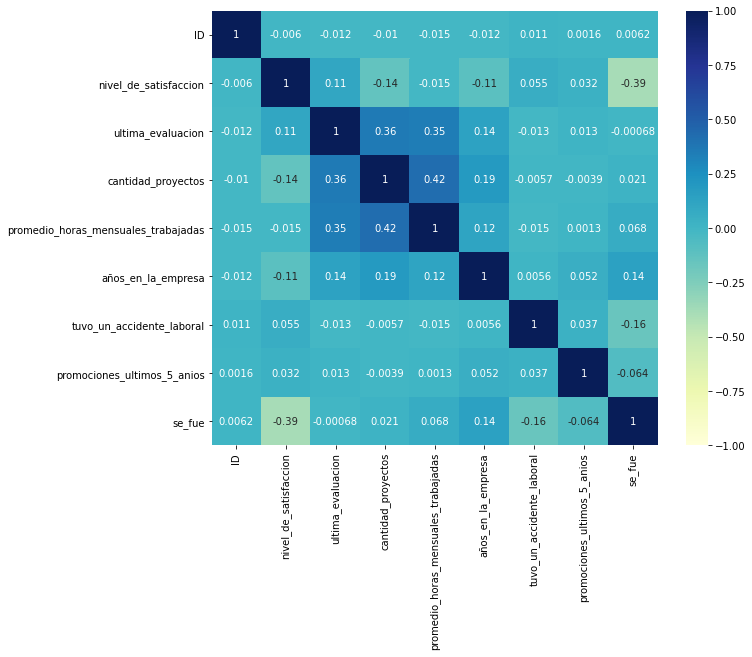

In [13]:
plt.figure(figsize=(10,8))

sns.heatmap(train_data.corr(), annot=True, cmap="YlGnBu", center=0, vmin=-1, vmax=1)

Puede observarse que no hay una correlacion muy fuerte entre las distintas variables, lo que estaria indicando que habria una relacion lineal debil, por lo tanto un modelo lineal de clasificacion (regresion logistica por ejemplo) no performaria bien.

In [14]:
# Antes de proceder a lo siguiente voy a separar mis columnas numericas de las categoricas.
num_cols = ['nivel_de_satisfaccion', 'ultima_evaluacion', 'cantidad_proyectos', 'promedio_horas_mensuales_trabajadas', 'años_en_la_empresa', ]
cat_cols = ['promociones_ultimos_5_anios', 'tuvo_un_accidente_laboral', 'area', 'salario']

In [15]:
# Ploteo todas mis columnas numericas.
for i in num_cols:
    fig = make_subplots(rows=1, cols=2)
    
    # Boxplot.
    tr1 = go.Box(y=train_data[i], name= 'Box Plot')
    
    # Grafico de barras.
    # empleados que se quedan en la empresa
    values_0 = train_data.query('se_fue==0')[i]
    tr2 = go.Histogram(x=values_0, name = 'Permanece')
    
    # empleados que se que abandonan la empresa.
    values_1 = train_data.query('se_fue==1')[i]
    tr3 = go.Histogram(x=values_1, name = 'Abandono')

    # Agrego los graficos al subplot creado
    fig.add_trace(tr1,row=1, col=1)
    fig.add_trace(tr2,row=1, col=2)
    fig.add_trace(tr3,row=1, col=2)
    
    fig.update_layout(height=500, width=1200, title_text='Distribucion: '+i, barmode='stack')
    fig.show()

De los graficos anteriores podemos decir que los empleados que tienen un grado de instasifaccion entre [0, 0.11] abandonaran el banco, y los empleados entre [0.36, 0.45] tienen altas probabilidades de abandonar el banco.

El puntaje que obtuvieron en la ultima evaluacion pareciera incidir sobre si un empleado se ira o no de la empresa, valores bajos [0.45, 0.57] o altos [0.77, 1] parecieran tener la mayoria de los empleados que abandonan.

En cuanto a los proyectos que tienen indicarian que pocos proyectos aumentan la probabilidad de que el empleado abandone la empresa. 

Las horas trabajadas parecieran tener uns distribucion similar a la variable 'ultima_evaluacion'.

Se puede ver que mientras mas años en la empresa menor es la probabilidad de que el empleado abandone la misma. Se puede observar la presencia de outliers, por lo que procederemos a eliminarlos luego del EDA. 

Ademas la gran mayoria de los empleados llevan 3 años en la empresa.

In [16]:
for i in cat_cols:
    specs = [[{'type':'histogram','rowspan':2}, {'type':'pie'}],
             [None, {'type':'pie'}]]
    
    fig = make_subplots(rows=2, cols=2,specs=specs, subplot_titles=('','<b>Permanece<b>', '<b>Abandona<b>'))
    
    # Ploteo mi histograma de la variable categorica i.
    tr1 = go.Histogram(x=train_data[i], name = i +  ' Histograma')
    
    # Query es como usar una mascara.
    # Me quedo con los empleados que se quedan en la empresa.
    # Del value_counts me quedo con los valores.
    value_0 = train_data.query('se_fue==0')[i].value_counts().values
    
    # Del value_counts me quedo conlos indices (etiquetas).
    labels_0 = train_data.query('se_fue==0')[i].value_counts().index.tolist()
    
    # Ploteo grafico dona de los empleados que permanecen en la empresa.
    tr2 = go.Pie(values=value_0, labels=labels_0, hole=0.4, name= 'Permanece')
    
    # empleados que abandonan la empresa.
    value_1 = train_data.query('se_fue==1')[i].value_counts().values
    labels_1 = train_data.query('se_fue==1')[i].value_counts().index
    
    tr3 = go.Pie(values=value_1, labels=labels_1, hole=0.4, name='Abandona')
    
    fig.add_trace(tr1, row=1, col=1)
    fig.add_trace(tr2, row=1, col=2)
    fig.add_trace(tr3, row=2, col=2)
    
    fig.update_layout(height=650, width=1000, title_text='Distribucion: '+i)
    fig.show()

El echo de que un empleado hasa sido promovido o no, no pareciera influir sobre la permanencia de un empleado.

La proporcion de empleados que sufrieron algun tipo de accidente es baja y de igual manera que la variable anterior no pareciera influir sobre si un empleado decidiera irse de la empresa o no.

En cuanto al area donde trabaja un empleado las distribuciones son similares para los empleados que abandonan el banco y los que no.

Cuando vemos la categoria salarial de un empleado, puede verse que aquellos empleados que tienen un salario bajo (la gran mayoria) tienen mayor probabilidad de abadonar la empresa.

In [17]:
# Voy a observar en que area se encuentran la mayor cantidad de empleados con salarios mas altos.
data_plot = train_data.groupby(['area', 'salario']).size()

fig = make_subplots(
                    rows = 2, 
                    cols = 5, 
                    specs = [
                            [{'type' : 'domain'} , {'type' : 'domain'}, {'type' :'domain'}, {'type' :'domain'}, {'type' :'domain'}],
                            [{'type' : 'domain'} , {'type' : 'domain'}, {'type' :'domain'}, {'type' :'domain'}, {'type' :'domain'}]
                           ], 
                    subplot_titles=('Soporte' , 'Ventas', 'RRHH', 'TI', 'Contabilidad', 'Dirección', 'gestion de productos', 'marketing', 'soporte', 'tecnica', 'ventas')
                    )

plt_soporte = go.Pie(labels= data_plot['soporte'].index, values= data_plot['soporte'].values)

plt_ventas = go.Pie(labels= data_plot['ventas'].index, values= data_plot['ventas'].values)

plt_rrhh = go.Pie(labels= data_plot['RRHH'].index, values= data_plot['RRHH'].values)

plt_ti = go.Pie(labels= data_plot['TI'].index, values= data_plot['TI'].values)

plt_contabilidad = go.Pie(labels= data_plot['contabilidad'].index, values= data_plot['contabilidad'].values)

plt_direccion = go.Pie(labels= data_plot['dirección'].index, values= data_plot['dirección'].values)

plt_gestion_productos = go.Pie(labels= data_plot['gestión de productos'].index, values= data_plot['gestión de productos'].values)

plt_marketing = go.Pie(labels= data_plot['marketing'].index, values= data_plot['marketing'].values)

plt_soporte = go.Pie(labels= data_plot['soporte'].index, values= data_plot['soporte'].values)

plt_tecnica = go.Pie(labels= data_plot['tecnica'].index, values= data_plot['tecnica'].values)

plt_ventas = go.Pie(labels= data_plot['ventas'].index, values= data_plot['ventas'].values)

fig.add_trace(plt_soporte,row=1,col=1)
fig.add_trace(plt_ventas, row=1, col=2)
fig.add_trace(plt_rrhh,row=1,col=3)
fig.add_trace(plt_contabilidad,row=1,col=4)
fig.add_trace(plt_direccion,row=1,col=5)

fig.add_trace(plt_gestion_productos,row=2,col=1)
fig.add_trace(plt_marketing,row=2,col=2)
fig.add_trace(plt_soporte,row=2,col=3)
fig.add_trace(plt_tecnica,row=2,col=4)
fig.add_trace(plt_ventas,row=2,col=5)

fig.update_layout(title_text='Proporcion de sueldos segun el area', height=800, width=1500)
fig.show()

Aqui podemos observar que en el area de contabilidad hay mayor cantidad de empleados con un sueldo alto.

Mientras que la menor cantidad de sueldos altos se encuentra en el area de ventas y tecnica.

El area de Soporte y marketing cuentan con la mayor cantidad de empleados con sueldos bajos.

Los sueldos medios son similares en todas las areas.

In [18]:
# Me voy a fijar si el area en la que trabajan influyen cuantos años hace que estan en la empresa.
data_plot = train_data.groupby(['area', 'años_en_la_empresa']).size()

fig = make_subplots(
                    rows = 2, 
                    cols = 5, 
                    specs = [
                            [{'type' : 'domain'} , {'type' : 'domain'}, {'type' :'domain'}, {'type' :'domain'}, {'type' :'domain'}],
                            [{'type' : 'domain'} , {'type' : 'domain'}, {'type' :'domain'}, {'type' :'domain'}, {'type' :'domain'}]
                           ], 
                    subplot_titles=('Soporte' , 'Ventas', 'RRHH', 'TI', 'Contabilidad', 'Dirección', 'gestion de productos', 'marketing', 'soporte', 'tecnica', 'ventas')
                    )

plt_soporte = go.Pie(labels= data_plot['soporte'].index, values= data_plot['soporte'].values)

plt_ventas = go.Pie(labels= data_plot['ventas'].index, values= data_plot['ventas'].values)

plt_rrhh = go.Pie(labels= data_plot['RRHH'].index, values= data_plot['RRHH'].values)

plt_ti = go.Pie(labels= data_plot['TI'].index, values= data_plot['TI'].values)

plt_contabilidad = go.Pie(labels= data_plot['contabilidad'].index, values= data_plot['contabilidad'].values)

plt_direccion = go.Pie(labels= data_plot['dirección'].index, values= data_plot['dirección'].values)

plt_gestion_productos = go.Pie(labels= data_plot['gestión de productos'].index, values= data_plot['gestión de productos'].values)

plt_marketing = go.Pie(labels= data_plot['marketing'].index, values= data_plot['marketing'].values)

plt_soporte = go.Pie(labels= data_plot['soporte'].index, values= data_plot['soporte'].values)

plt_tecnica = go.Pie(labels= data_plot['tecnica'].index, values= data_plot['tecnica'].values)

plt_ventas = go.Pie(labels= data_plot['ventas'].index, values= data_plot['ventas'].values)

fig.add_trace(plt_soporte,row=1,col=1)
fig.add_trace(plt_ventas, row=1, col=2)
fig.add_trace(plt_rrhh,row=1,col=3)
fig.add_trace(plt_contabilidad,row=1,col=4)
fig.add_trace(plt_direccion,row=1,col=5)

fig.add_trace(plt_gestion_productos,row=2,col=1)
fig.add_trace(plt_marketing,row=2,col=2)
fig.add_trace(plt_soporte,row=2,col=3)
fig.add_trace(plt_tecnica,row=2,col=4)
fig.add_trace(plt_ventas,row=2,col=5)

fig.update_layout(title_text='Proporcion de años en la empresa segun el area', height=800, width=1500)
fig.show()

Puede verse que la mayoria de los clientes que llevan 10 años en la empresa se encuentran en el area de contabilidad.

En todas las areas, menos la de contabilidad, la distribucion de los años en la empresa es similar.

In [19]:

# Voy a er si segun la cantidad de años que llevan en la empresa cual es el nivel de satisfaccion promedio.
data_plot = train_data.groupby(['años_en_la_empresa'])['nivel_de_satisfaccion'].mean()
fig = px.bar(data_plot, x=data_plot.index, y=data_plot.values, title='Nivel de insatisfaccion segun el los años en la empresa', labels={'y':'Nivel de satisfaccion'})
fig.update_layout(height=500, width=1500)
fig.show()

Se puede ver que el nivel de satisfaccion mas alto se da por lo general cuando el empleado lleva dos años en la empresa. Luego de esos dos años el nivel cae hasta los mas bajo que se da cuando el empleado lleva 4 años en la empresa, donde luego vuelve a aumentar.

In [20]:
# Veo como varia la cantidad de horas mensuales que trabaja un empleado dependiendo de los años en la empresa.
data_plot = train_data.groupby(['años_en_la_empresa'])['promedio_horas_mensuales_trabajadas'].mean()
fig = px.bar(data_plot, x=data_plot.index, y=data_plot.values, title='promedio de horas trabajadas segun el los años en la empresa', labels={'y':'Horas trabajadas promedio'})
fig.update_layout(height=500, width=1500)
fig.show()

Puede verse que los empleados que estan hace 4 o 5 años en la empresa son los que mayor cantidad de horas promedio mensuales trabajan.

En contraste con el grafico anterior puede intuirse que debido a que los que llevan 4 años en la empresa son los que mas trabajan, su nivel de satisfaccion baja.

In [21]:
# Veo como varia la cantidad de proyectos en funcion del nivel de satisfaccion.
data_plot = train_data.groupby(['cantidad_proyectos'])['nivel_de_satisfaccion'].mean()
fig = px.bar(data_plot, x=data_plot.index, y=data_plot.values, title='Nivel de satisfaccion segun la cantidad de proyectos', labels={'y':'Nivel de satisfaccion'})
fig.update_layout(height=500, width=1500)
fig.show()

Puede verse que luego luego de que un empleado tenga mas de 5 proyectos su nivel de satisfaccion baja considerablemente.

Y que para un empleado tener dos proyectos baja el nivel de satisfaccion.

In [22]:
# Me voy a fijar si a mayor cantidad de proyectos mayor cantidad de horas trabajadas.
data_plot = train_data.groupby(['cantidad_proyectos'])['nivel_de_satisfaccion'].mean()
fig = px.bar(data_plot, x=data_plot.index, y=data_plot.values, title='Cantidad de horas trabajadas segun la cantidad de proyectos', labels={'y':'Promedio de horas trabajadas'})
fig.update_layout(height=500, width=1500)
fig.show()

Puede verse que a mayor cantidad de proyectos mayor cantidad de horas trabaja un empleado, lo que tendria sentido.

## Outliers

Como se pudo ver en la variable 'años_en_la_empresa' hay presencia de outliers, por lo tanto los voy a eliminar de manera muy simple, aplicando una mascara, ya que se trata de una unica variable, ademas de que es mas rapido y facil filtrar los datos de esta manera.

In [23]:
# Creo una mascara para quedarme con los valores menores a 5 años.
mask = train_data['años_en_la_empresa'] <= 5

# Vamos a ver cuantos elementos filtramos.
print('Elementos antes - %s' %(train_data.shape[0]))

# Aplico la mascara.
train_data = train_data[mask]

# Vemos elementos despues.
print('Elementos despues - %s' %(train_data.shape[0]))

fig = px.box(train_data, y='años_en_la_empresa')
fig.update_layout(height=500, width=1000)
fig.show()

Elementos antes - 8000
Elementos despues - 7307


## Preparacion del dataset

Antes de entrenar un modelo y predecir la solucion que se me pide, debo preparar el dataset, para esto hare los siguiente:

- Dividir los datos en train y test.
- Normalizar las variables numericas.
- Balancear la clase target.
- Dumificar las variables categoricas.

Primero voy a divdir el dataset en datos de entrenamiento y datos de testeo.

In [24]:
X_train = train_data.drop(columns=['ID', 'se_fue'])
y_train = train_data['se_fue']
X_test = test_data.drop(columns=['ID', 'se_fue'])

X_train.shape, y_train.shape, X_test.shape

((7307, 9), (7307,), (2000, 9))

### Balanceo de clase target
Primero que nada voy a balancear la clase target, voy a aplicar oversampling (aumentando los casos de la clase minoritaria) mediante SMOTENC, este algoritmo genera muestras imuladas de la clase minoritaria.

Ya que para hacer oversample vamos a usar SMOTENC, el cual genera muestras mediante un algoritmo KNN (utiliza la distancia euclideana para generar las muestras), voy a necesitar que el dataset este normalizado previamente.

In [25]:
# Voy a obtener los indices de mis columnas categoricas para pasarselas a SMOTENC.
cat_cols_pos = []
for pos, i in enumerate(X_train.columns):
    if i in cat_cols:
        cat_cols_pos.append(pos)

print('Posicion de las columnas categoricas - %s' %(cat_cols_pos))



Posicion de las columnas categoricas - [5, 6, 7, 8]


In [26]:
# Voy a normalizar mis variables numericas unicamente.
# Primero instancio el StandardScaler.
scaler = StandardScaler()
# Luego fiteo y transformo con mis datos de train.
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
# Por ultimo transformo mis datos de entrenamiento.
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Ahora procedo al balanceo de clases.
# Instancio el modelo de oversample.
sm = SMOTENC(categorical_features=cat_cols_pos, sampling_strategy='minority', random_state=10)
# Resampleo mis datos de train.
X_train, y_train = sm.fit_resample(X_train, y_train)

In [27]:
print('Balance de clases antes de aplicar SMOTENC')
train_data['se_fue'].value_counts()

Balance de clases antes de aplicar SMOTENC


0    5535
1    1772
Name: se_fue, dtype: int64

In [28]:
print('Balance de clases despues de aplicar SMOTENC')
y_train.value_counts()

Balance de clases despues de aplicar SMOTENC


1    5535
0    5535
Name: se_fue, dtype: int64

Ahora con la clase target balanceada voy a proceder a realizar la dumificacion de las variables categoricas (pasar las variables categoricas a numericas).

In [29]:
# Instancio onehot.
enc = OneHotEncoder(drop='first')
# Fiteo y transformo mis datos de train, creo un dataframe.
one_hot_cat_train = pd.DataFrame(data=enc.fit_transform(X_train[['area','salario']]).toarray(), columns=enc.get_feature_names(['area', 'salario']))
# Transformo los datos de test
one_hot_cat_test = pd.DataFrame(data=enc.transform(X_test[['area','salario']]).toarray(), columns=enc.get_feature_names(['area', 'salario']))

In [30]:
# Ahora voy a unir las variables dummificadas y mis datos de train
# Dropeo las columnas que ya fueron dumificadas
X_train.drop(columns=['area','salario'], inplace=True)
# Concateno los datos de train con las variables a las cuales les aplique OneHot
X_train = pd.concat([X_train, one_hot_cat_train], axis=1)

print(X_train.shape)
X_train.head(3)

(11070, 18)


,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios,area_RRHH,area_TI,area_contabilidad,area_dirección,area_gestión de productos,area_marketing,area_soporte,area_tecnica,area_ventas,salario_bajo,salario_medio
0,0.079453,0.732172,-0.626756,1.365943,-1.267449,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-2.014116,1.258342,2.580323,1.666136,0.928982,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.927071,-1.314045,0.175013,-0.094998,-0.169234,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Hago lo mismo para mis datos de test.
X_test.drop(columns=['area','salario'], inplace=True)
X_test = pd.concat([X_test, one_hot_cat_test], axis=1)

print(X_test.shape)
X_test.head(3)

(2000, 18)


,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios,area_RRHH,area_TI,area_contabilidad,area_dirección,area_gestión de productos,area_marketing,area_soporte,area_tecnica,area_ventas,salario_bajo,salario_medio
0,-0.846549,-0.846338,-1.428526,-0.975564,-0.169234,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.282896,-1.138655,-0.626756,-1.716041,-0.169234,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.441801,0.907562,0.976783,0.445350,2.027197,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Modelos y resultados

Ahora plantearemos diferentes modelos para ver cual performa mejor de todos, los modelos a emplear seran:

- Knn o  K-nearest neighbors
- Regression Logistica
- Extra Trees
- Random Forest
- XGBoost

Ya que no cuento con datos de test para poder evaluar la performance, con datos desconocidos por el modelo, voy a evaluar con los datos de train los distintos modelos con sus hiperparametros por defecto.

CONSIDERACION: Ya que estamos tratando de predecir si un empleado se ira de la empresa, considero que es mas importante que el modelo sea mejor prediciendo la instancia positiva, por lo tanto la metrica a la que le daremos importancia sera la de F1-Score.

F1-Score es la medida armonica entre Recall y precision.

- Recall (sensibilidad o true positive rate): Mide la capacidad del modelo de detectar los verdaderos positivos (TP) sobre todos los casos positivos (TP + FN).

- Precision (o positive predictive value): Mide que tan preciso es el clasificador al predecir las instancias positias. se representa como los verdaderos positivos (TP) sobre el total de las predicciones positivas (TP + FP).

In [32]:
# Folds que voy a aplicar en cross val score.
folds = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

# Diccionario con los diferentes modelos a evaluar.
classifiers = {
            'KNN': KNeighborsClassifier(),
            'RegresionLogistica' : LogisticRegression(penalty='none'),
            'ExtraTrees' : ExtraTreesClassifier(random_state=10),
            'RandomForest' : RandomForestClassifier(random_state=10),
            'AdaBoost' : AdaBoostClassifier(random_state=10),
            'XGBoost' : XGBClassifier(random_state=10)
            }

# DataFrame para guardar los valores de las metricas.
df_metrics = pd.DataFrame(columns=['classifier', 'avg_f1'])

for nombre, clf in classifiers.items():
    # Instancio el modelo
    model = clf
    
    # Evaluo f1-score con validacion cruzada usanco 'cross_val_score'.
    cv_result = cross_val_score(model, X_train, y_train, cv=folds, scoring='f1')
    
    # Agrego las metricas al DF.
    df_metrics = df_metrics.append({'classifier' : nombre, 'avg_f1' : cv_result.mean()}, ignore_index=True)

# Ploteo el resultado
fig = px.bar(df_metrics, x='avg_f1', y='classifier', text_auto=True)
fig.update_layout(height=500, width=750)
fig.show()
    

Aca se puede ver la performance con los datos de train de los distintos modelos planteados. Los dos mejores modelos fueron RandomForest y XGBoost, por lo tanto ahora procederemos a ajustar los hiperparametros mediante grid search de ambos modelos.

In [33]:
# Voy a modificar primero los hiperparametros de RandomForest.
# Instancio mi modelo de Random Forest.
rf_model = RandomForestClassifier(random_state=10)

# Creo la grilla de hiperparametros a modificar.
rf_grid_params = {
                'n_estimators' : [50,100,150],
                'criterion' : ['gini', 'entropy'],
                'max_depth' : [2,10,None],
                'max_features' : ['sqrt', 'log2'],
                'max_leaf_nodes' : [2,10,None]
                }

# Determino la estrategia de cross-validation.
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Instancio gridsearchCV.
clf_rf = GridSearchCV(rf_model, rf_grid_params, cv=folds, scoring='f1')
# fiteo mi modelo.
clf_rf.fit(X_train, y_train)

print('Mejor Score - %s' %(clf_rf.best_score_))
print('Mejores hiperparametros - %s' %(clf_rf.best_params_))

Mejor Score - 0.9840255798105584
Mejores hiperparametros - {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'n_estimators': 150}


In [34]:
xg_model = XGBClassifier(random_state=10, verbosity=0)

xg_grid_params = {
                'n_estimators' : [50,100,150],
                'max_depth' : [2,10,None],
                'learning_rate' : [0.25,1,1.5],
                'grow_policy' : ['depthwise', 'lossguide']
                }

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Instancio gridsearchCV.
clf_xg = GridSearchCV(xg_model, xg_grid_params, cv=folds, scoring='f1')
# fiteo mi modelo.
clf_xg.fit(X_train, y_train)

print('Mejor Score - %s' %(clf_xg.best_score_))
print('Mejores hiperparametros - %s' %(clf_xg.best_params_))

Mejor Score - 0.9863830973155279
Mejores hiperparametros - {'grow_policy': 'depthwise', 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 100}


Podemos ver que el modelo que mejor performo aqui fue el de XGBoost, por poco.

Por lo tanto seleccionaremos ese modelo para realizar las predicciones.

## Feature Selection
Antes de proceder a realizar las predicciones voy a identificar y seleccionar las variables mas relevantes, para ver si seleccionandolas podemos mejorar un poco mas la performance del modelo.

Para hacer esto voy a usar la clase SelectFromModel de Scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html), la cual es un meta-tranformador que selecciona las mejores variables de un determinado dataset de acuerdo a la importanca de los pesos segun el modelo empleado.

In [35]:
# Primero voy a instanciar el modelo a utilizar, con los hiperparametros obtenidos de gridsearchCV.
estimator = XGBClassifier(grow_policy='depthwise', learning_rate=0.25, max_depth=10, n_estimators=100, random_state=10, verbosity=0)

# Instancio SelectFromModel
selector = SelectFromModel(estimator,threshold='median')
# Fiteo el selector.
selector.fit(X_train, y_train)

# Obtengo las columnas seleccionadas por SelectFromModel.
X_train_selector = X_train.loc[:,selector.get_support()]
print('Shape luego de aplicar feature selection - %s filas x %s columnas' %(X_train_selector.shape[0], X_train_selector.shape[1]))
X_train_selector.head(3)



Shape luego de aplicar feature selection - 11070 filas x 9 columnas


,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,area_contabilidad,area_dirección,area_ventas
0,0.079453,0.732172,-0.626756,1.365943,-1.267449,0,0.0,0.0,0.0
1,-2.014116,1.258342,2.580323,1.666136,0.928982,0,0.0,0.0,0.0
2,-0.927071,-1.314045,0.175013,-0.094998,-0.169234,0,0.0,1.0,0.0


Una vez seleccionadas las features mas importantes voy a evaluar el modelo con dichas features.

In [36]:
# Voy a usar el modelo instanciado arriba.
# Folds que voy a aplicar en cross val score.
folds = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

# Evaluo f1-score con validacion cruzada usanco 'cross_val_score' y usando las features seleccionadas.
cross_val_selector = cross_val_score(estimator, X_train_selector, y_train, cv=folds, scoring='f1')
print('F1-Score SelectFromModel - %s' %(cross_val_selector.mean()))

F1-Score SelectFromModel - 0.985826886350498


Podemos ver que aplicar un metodo de seleccion de features para este dataset no trajo nigun beneficio a la performance del modelo, por esa razon no la tendre en cuenta.

Seleccionare como modelo ganador al modelo de XGBoost con la optimizacion de hiperparametros.

## Prediccion final.

Ahora que ya tengo el modelo ganador voy a proceder a realizar las predicciones de los datos de test, para asi finalizar este ejercicio.

In [37]:
# Instancio el modelo de XGBoost.
final_model = XGBClassifier(grow_policy='depthwise', learning_rate=0.25, max_depth=10, n_estimators=100, random_state=10, verbosity=0)

# Fiteo el modelo.
final_model.fit(X_train, y_train)

# Predigo los datos de test y los agrego al dataframe de test.
test_data['se_fue'] = final_model.predict(X_test)
entrega = test_data[['ID', 'se_fue']]
entrega.to_csv('resultado_ejercicio_data_science.csv')

In [38]:
entrega

,ID,se_fue
0,2.0,1
1,4.0,0
2,9.0,1
3,14.0,0
4,15.0,0
...,...,...
1995,9980.0,0
1996,9987.0,1
1997,9991.0,1
1998,9996.0,0
